Multi armed bandit Epsilon Greedy
Q(St, AL) = Q(St, Al) (current) + a(Ri+1 + y maxa Q(St+1,a) - Q(St, At)) for Q value update

In [1]:
# Importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# Defining the Bandit class

class Bandit:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        # set the mean and standard deviation for each bandit machine
        self.means=np.random.normal(0, 1, self.num_arms)
        # Use the uniform distribution to generate standard deviation
        self.standards=np.random.uniform(0, 1, self.num_arms)

    def pull_arm(self, arm):
        # Pulling and receiving a stochastic reward
        return np.random.normal(self.means[arm],self.standards[arm])

    def best_arm(self):
        # Return index of the arm with the highest true value
        return np.argmax(self.means)

In [3]:
class EGreedySimulation:
    def __init__(self, bandit, rate, num_plays):
        self.bandit = bandit
        self.rate = rate
        self.num_plays = num_plays
        self.estimated_values = np.zeros(bandit.num_arms)
        self.pull_times = np.zeros(bandit.num_arms)

    def explore_exploit_policy(self):
        if np.random.random() < self.rate:
            # Exploration
            return np.random.choice(len(self.estimated_values))
        else:
            # Exploitation
            # Choose best arm based on estimated values
            return np.argmax(self.estimated_values)

    def simulate(self):
        rewards = np.zeros(self.num_plays)
        optimal_times = np.zeros(self.num_plays)

        for round in range(self.num_plays):
            chosen_arm = self.explore_exploit_policy()
            reward = self.bandit.pull_arm(chosen_arm)
            self.pull_times[chosen_arm] += 1
            self.estimated_values[chosen_arm] += (reward - self.estimated_values[chosen_arm]) / self.pull_times[chosen_arm]
            rewards[round] = reward
            if chosen_arm == self.bandit.best_arm():
                optimal_times[round] = 1

        # Calculate the average and cumulative rewards and optimal times
        average_rewards = np.cumsum(rewards) / np.arange(1, self.num_plays + 1)
        average_optimal_times = np.cumsum(optimal_times) / np.arange(1, self.num_plays + 1)
        cumulative_rewards = np.cumsum(rewards)
        cumulative_optimal_times = np.cumsum(optimal_times)
        return average_rewards, average_optimal_times, cumulative_rewards, cumulative_optimal_times

In [4]:
class UCB_strategy:
    def __init__(self, num_arms,num_plays):
        self.num_arms = num_arms
        self.num_plays=num_plays
        # Set the counts and the values
        self.pull_times = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        return

    def select(self):
        # Try every arm
        for i in range(self.num_arms):
            if self.pull_times[i] == 0:
                return i
        # Calculate the total times
        total_times = sum(self.pull_times)
        # Calculate the upper confidence bound
        upper_confidence_bound = self.values + np.sqrt(np.log(total_times) / (self.pull_times + 1e-8))
        return np.argmax(upper_confidence_bound)

    def update(self, arm, reward):
        self.pull_times[arm] = self.pull_times[arm] + 1
        i_times = self.pull_times[arm]
        value = self.values[arm]
        self.values[arm] += (reward-value)/float(i_times)
        return

def ucbSimulation(bandit, num_plays):
    myUCB=UCB_strategy(bandit.num_arms,num_plays)
    rewards=np.zeros(num_plays)
    optimal_times = np.zeros(num_plays)
    for i in range (num_plays):
        chosen_arm=myUCB.select()
        reward=bandit.pull_arm(chosen_arm)
        myUCB.update(chosen_arm,reward)
        rewards[i]=reward
        if chosen_arm == bandit.best_arm():
            # Record the optimal times
            optimal_times[i] = 1
    average_rewards = np.cumsum(rewards) / np.arange(1, num_plays + 1)
    average_optimal_times = np.cumsum(optimal_times) / np.arange(1, num_plays + 1)

    cumulative_rewards = np.cumsum(rewards)
    cumulative_optimal_times = np.cumsum(optimal_times)
    return average_rewards, average_optimal_times, cumulative_rewards, cumulative_optimal_times

In [5]:
class TS_strategy:
    def __init__(self, num_arms):
        self.n_arms = num_arms
        # Set the success and failure counts for each arm
        self.alpha = np.ones(num_arms)
        self.beta = np.ones(num_arms)
        self.choices = []
        self.rewards = np.zeros((num_arms, 0))

    # Select an arm to play
    def select_arm(self):
        sampled_theta = [np.random.beta(a, b) for a, b in zip(self.alpha, self.beta)]
        return np.argmax(sampled_theta)

    def update(self, chosen_arm, reward):
        if reward > 0:
            self.alpha[chosen_arm] += 1
        else:
            self.beta[chosen_arm] += 1
        # Update the choices and rewards
        self.choices.append(chosen_arm)
        reward_update = np.zeros(self.n_arms)
        reward_update[chosen_arm] = reward
        self.rewards = np.hstack([self.rewards, reward_update.reshape(-1, 1)])

def ThompsonSamplingSimulation(bandit, num_arms, num_plays):
    TSampling=TS_strategy(num_arms=num_arms)
    rewards = np.zeros(num_plays)
    optimal_times = np.zeros(num_plays)

    # Simulate the multi-armed bandit process
    for i in range(num_plays):
      chosen_arm = TSampling.select_arm()
      reward = bandit.pull_arm(chosen_arm)
      TSampling.update(chosen_arm, reward)
      rewards[i]=reward
      if chosen_arm == bandit.best_arm():
              # Record the optimal times
              optimal_times[i] = 1
    total_reward = sum(rewards)

    # Calculate the average and cumulative rewards and optimal times
    average_rewards = np.cumsum(rewards) / np.arange(1, num_plays + 1)
    average_optimal_times = np.cumsum(optimal_times) / np.arange(1, num_plays + 1)
    cumulative_rewards = np.cumsum(rewards)
    cumulative_optimal_times = np.cumsum(optimal_times)

    return total_reward, cumulative_rewards, average_rewards, average_optimal_times, cumulative_optimal_times

In [6]:
num_arms = 10
num_plays = 2000
num_trials = 1000

In [7]:
exploration_rates = [0.0, 0.01, 0.1]

# Simulate the bandit game for different exploration rates
e_greedy_avgRewards = {rate: np.zeros((num_trials, num_plays)) for rate in exploration_rates}
e_greedy_avgOptimal = {rate: np.zeros((num_trials, num_plays)) for rate in exploration_rates}

e_greedy_cumRewards = {rate: np.zeros((num_trials, num_plays)) for rate in exploration_rates}
e_greedy_cumOptimal = {rate: np.zeros((num_trials, num_plays)) for rate in exploration_rates}

for trial in range(num_trials):
    for rate in exploration_rates:
        bandit = Bandit(num_arms)
        EGreedy = EGreedySimulation(bandit, rate, num_plays)
        average_rewards, average_optimal_actions, cumulative_rewards, optimal_cumulative_rewards = EGreedy.simulate()
        e_greedy_avgRewards[rate][trial, :] = average_rewards
        e_greedy_avgOptimal[rate][trial, :] = average_optimal_actions

        e_greedy_cumRewards[rate][trial, :] = cumulative_rewards
        e_greedy_cumOptimal[rate][trial, :] = optimal_cumulative_rewards

# Calculate the average rewards and optimal times
e_greedy_avg_avgRewards = {rate: e_greedy_avgRewards[rate].mean(axis=0) for rate in exploration_rates}
e_greedy_avg_avgOptimal = {rate: e_greedy_avgOptimal[rate].mean(axis=0) for rate in exploration_rates}

e_greedy_cum_avgRewards = {rate: e_greedy_cumRewards[rate].mean(axis=0) for rate in exploration_rates}
e_greedy_cum_avgOptimal = {rate: e_greedy_cumOptimal[rate].mean(axis=0) for rate in exploration_rates}

In [8]:
ucb_avgRewards = np.zeros((num_trials, num_plays))
ucb_avgOptimal = np.zeros((num_trials, num_plays))

ucb_cumRewards = np.zeros((num_trials, num_plays))
ucb_cumOptimal = np.zeros((num_trials, num_plays))

for trial in range(num_trials):
    bandit = Bandit(num_arms)
    avg_rewards, avg_optimal_actions, cum_rewards, cum_optimal_actions = ucbSimulation(bandit, num_plays)
    ucb_avgRewards[trial, :] = avg_rewards
    ucb_avgOptimal[trial, :] = avg_optimal_actions

    ucb_cumRewards[trial, :] = cum_rewards
    ucb_cumOptimal[trial, :] = cum_optimal_actions

ucb_avg_avgRewards = ucb_avgRewards.mean(axis=0)
ucb_avg_avgOptimal = ucb_avgOptimal.mean(axis=0)

ucb_avg_cumRewards = ucb_cumRewards.mean(axis=0)
ucb_avg_cumOptimal = ucb_cumOptimal.mean(axis=0)

In [9]:
TS_totalRewards = np.zeros(num_trials)
TS_avgRewards = np.zeros((num_trials, num_plays))
TS_cumRewards = np.zeros((num_trials, num_plays))
TS_avgOptimal = np.zeros((num_trials, num_plays))
TS_cumOptimal = np.zeros((num_trials, num_plays))

for trial in range(num_trials):
    bandit = Bandit(num_arms)
    total_reward, TS_cumulative_rewards, TS_average_rewards, TS_average_optimal_times, TS_cumulative_optimal_times = ThompsonSamplingSimulation(bandit, num_arms, num_plays)
    TS_totalRewards[trial]=total_reward
    TS_cumRewards[trial,:]=TS_cumulative_rewards
    TS_avgRewards[trial,:]=TS_average_rewards
    TS_avgOptimal[trial,:]=TS_average_optimal_times
    TS_cumOptimal[trial,:]=TS_cumulative_optimal_times

TS_avg_totalRewards=TS_totalRewards.mean()
TS_avg_cumRewards=  TS_cumRewards.mean(axis=0)
TS_avg_avgRewards=  TS_avgRewards.mean(axis=0)
TS_avg_cumOptimal=  TS_cumOptimal.mean(axis=0)
TS_avg_avgOptimal=  TS_avgOptimal.mean(axis=0)

In [10]:
def plot_ucb(rewards, optimal_times,label_1,title):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    # Plotting the rewards over time
    plt.plot(rewards)
    plt.xlabel('Plays')
    plt.ylabel(f'{label_1} Rewards')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # Plotting the optimal times over time
    plt.plot(optimal_times)
    plt.xlabel('Plays')
    plt.ylabel(f'{label_1} Optimal times')
    plt.grid(True)
    plt.figtext(0.5, 0.95, f'{title} {label_1} Performance', ha='center', va='center', fontsize=16)
    plt.show()

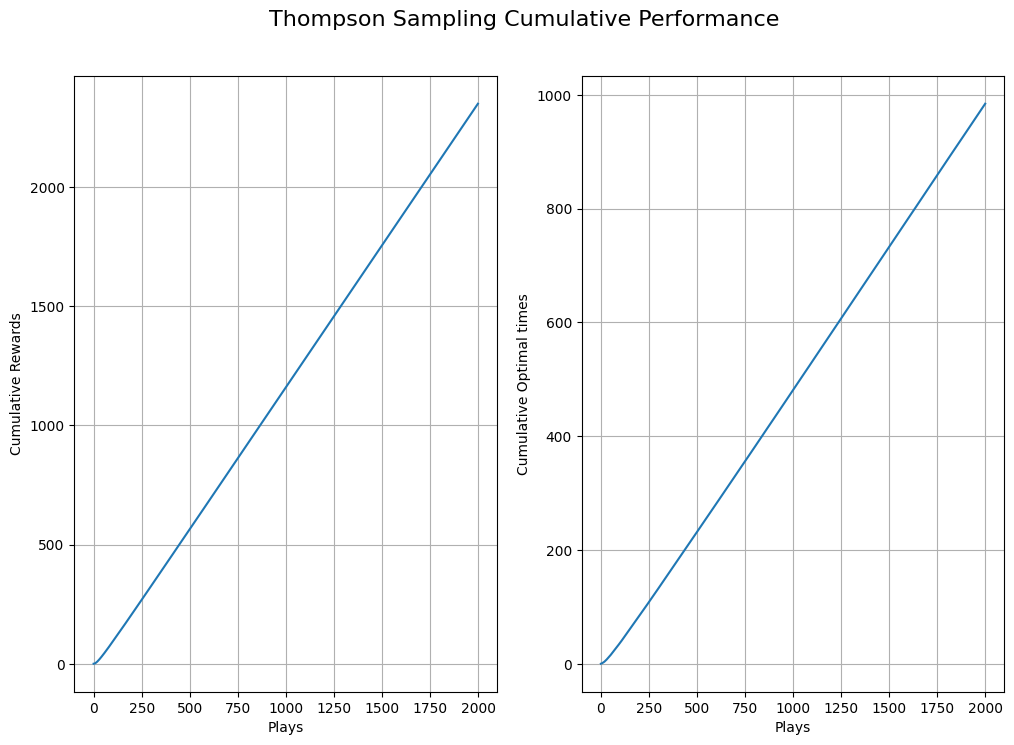

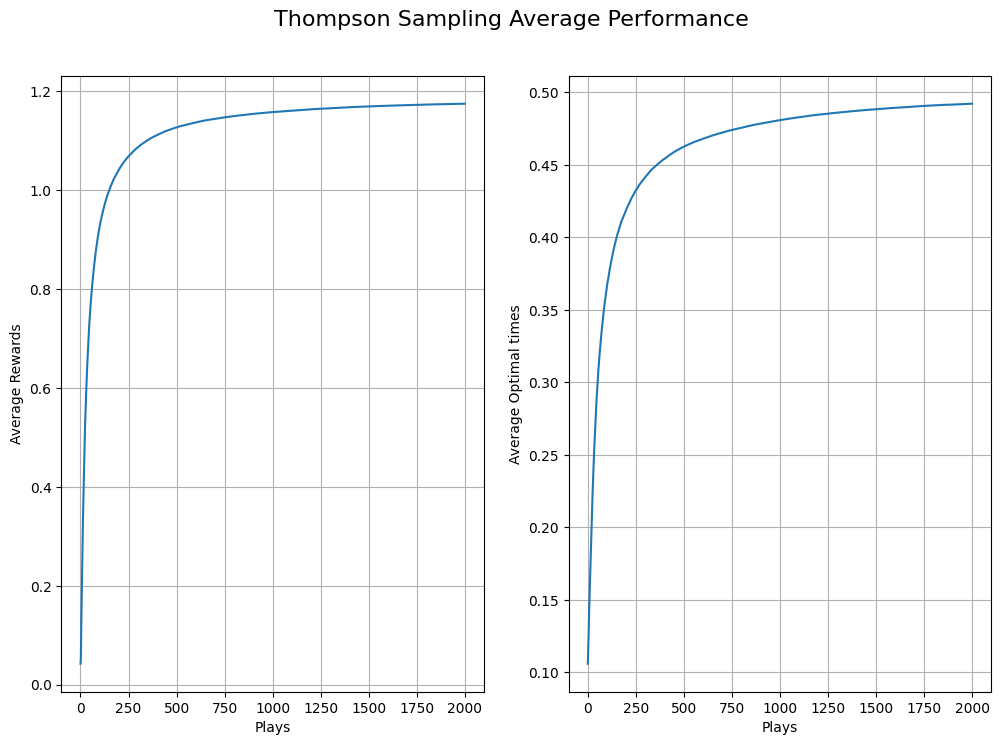

In [11]:
plot_ucb(TS_avg_cumRewards, TS_avg_cumOptimal,'Cumulative','Thompson Sampling')
plot_ucb(TS_avg_avgRewards, TS_avg_avgOptimal,'Average','Thompson Sampling')